# I. Set Up

In [11]:
# PYTHON Imports 
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import math
import statistics
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pathlib import Path
import glob
import os
import ipywidgets as widgets
from IPython.display import clear_output
import sys
import time
import json
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import seaborn as sns
import fnmatch
# ASTROPHY Imports
import astropy 
from astropy.table import Table
from astropy.io import fits
from sherpa.astro import ui
# CIAO Imports
import ciao_contrib.runtool
from ciao_contrib.runtool import *
# CUSTOM Imports
from data_extraction_functions import *
from data_exploration_functions import *
from data_representation_functions import *

# Specify global path
global_path = '/Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets'
global_folders = list_folders_fun(global_path)

# Custom object hook to convert lists of lists to NumPy arrays
def numpy_hook(obj):
    if isinstance(obj, list):
        # Check if the list contains sublists (i.e. a matrix)
        if isinstance(obj[0], list):
            # Convert the list of lists to a NumPy array matrix
            return np.array(obj)
    # Return all other objects as is
    return obj

# Select dataset
set_widget = widgets.Dropdown(options=global_folders[:],value=global_folders[0],description='Set :',disabled=False); set_widget

Dropdown(description='Set :', options=('All', 'Bona'), value='All')

# II. Load Data

In [2]:
# Set ID
set_id = set_widget.value
# Select Input
files = os.listdir(f'{global_path}/{set_id}/')
input_files = [f for f in files if fnmatch.fnmatch(f, 'hist*')]
input_widget = widgets.Dropdown(options=input_files[:],value=input_files[0],description='TSNE File :',disabled=False); input_widget


Dropdown(description='TSNE File :', options=('hist3D-All-nE20-nt30-ndt35.pkl', 'histEt-All-nE20-nt25-normnone.…

In [4]:
# Load the DataFrame from the CSV file
input_file = input_widget.value
# Load histogram dictionary
# with open(f'{global_path}/{set_id}/{input_file}', "r") as f:
#     hist_dict = json.load(f, object_hook=numpy_hook)
with open(f'{global_path}/{set_id}/{input_file}', 'rb') as f:
    hist_dict = pickle.load(f)
# Flatten histograms in the dictionary and get IDs
ids = hist_dict.keys()
histograms = hist_dict.values()
features = np.array([np.array(h).flatten() for h in histograms])
features[np.isnan(features)] = 0.0
# Load properties
df_properties_input = pd.read_csv(f'{global_path}/{set_id}/properties-input-{set_id}.csv')
df_properties_input = df_properties_input[df_properties_input['obsreg_id'].isin(list(ids))]
df_properties = df_properties_input.drop_duplicates('obsreg_id', keep='first')

# Print eventfiles and properties number of IDs
print("Number of Features: ", len(features))
print("Number of Property Sets: ", len(df_properties))

Number of Features:  82283
Number of Property Sets:  82283


# III. TSNE

TSNE Model

In [3]:
# TSNE Setting
n_comp = 2
perp = 75
learn_rate = 25
early_exag = 3
iterations = 2000

# Define TSNE Model
tsne_model = TSNE(n_components = n_comp , perplexity = perp, learning_rate = learn_rate, n_iter = iterations, early_exaggeration = early_exag, init='random')
# Run TSNE Model on Data
tsne_out = tsne_model.fit_transform(features)
print(tsne_out.shape)

# Save TSNE Output
df_tsne = pd.DataFrame(tsne_out, columns=['tsne1', 'tsne2'])
df_tsne['obsreg_id'] = list(ids)
input_file = input_widget.value
data_rep = input_file.split(".pkl")[0]
df_tsne.to_csv(f'{global_path}/{set_id}/tsne-{set_id}-{data_rep}-{n_comp}D-perp{perp}-lr{learn_rate}-ee{early_exag}-it{iterations}.csv', index=False)


NameError: name 'features' is not defined

Plot TSNE

In [7]:
files = os.listdir(f'{global_path}/{set_id}/')
tsne_files = [f for f in files if fnmatch.fnmatch(f, 'tsne*')]
tsne_widget = widgets.Dropdown(options=tsne_files[:],value=tsne_files[0],description='TSNE File :',disabled=False); tsne_widget

Dropdown(description='TSNE File :', options=('tsne-All-histEt-All-nE20-nt25-normnone-2D-perp100-lr10-ee2-it100…

In [10]:
# Load the DataFrame from the CSV file
tsne_file = tsne_widget.value
df_tsne = pd.read_csv(f'{global_path}/{set_id}/{tsne_file}')
# Use loc to select rows that match the IDs in list2, and store the result in a new DataFrame
flares = ['9109_333','9109_344','13637_1078','14368_489','14368_503','14431_16','14542_18','10822_185','10955_21','10996_5','2833_53','13610_112','15214_29']
dips = ['10783_10','10871_10','11059_10','9070_10','9072_10','13814_567','13682_9','1708_192','1708_193','1712_91','15553_237','13681_9','13813_86']
rosanne = ['13814_567']
tsne_flares = df_tsne.loc[df_tsne['obsreg_id'].isin(flares)]
tsne_dips = df_tsne.loc[df_tsne['obsreg_id'].isin(dips)]
tsne_rosanne = df_tsne.loc[df_tsne['obsreg_id'].isin(rosanne)]

ValueError: 'c' argument has 82283 elements, which is inconsistent with 'x' and 'y' with size 62989.

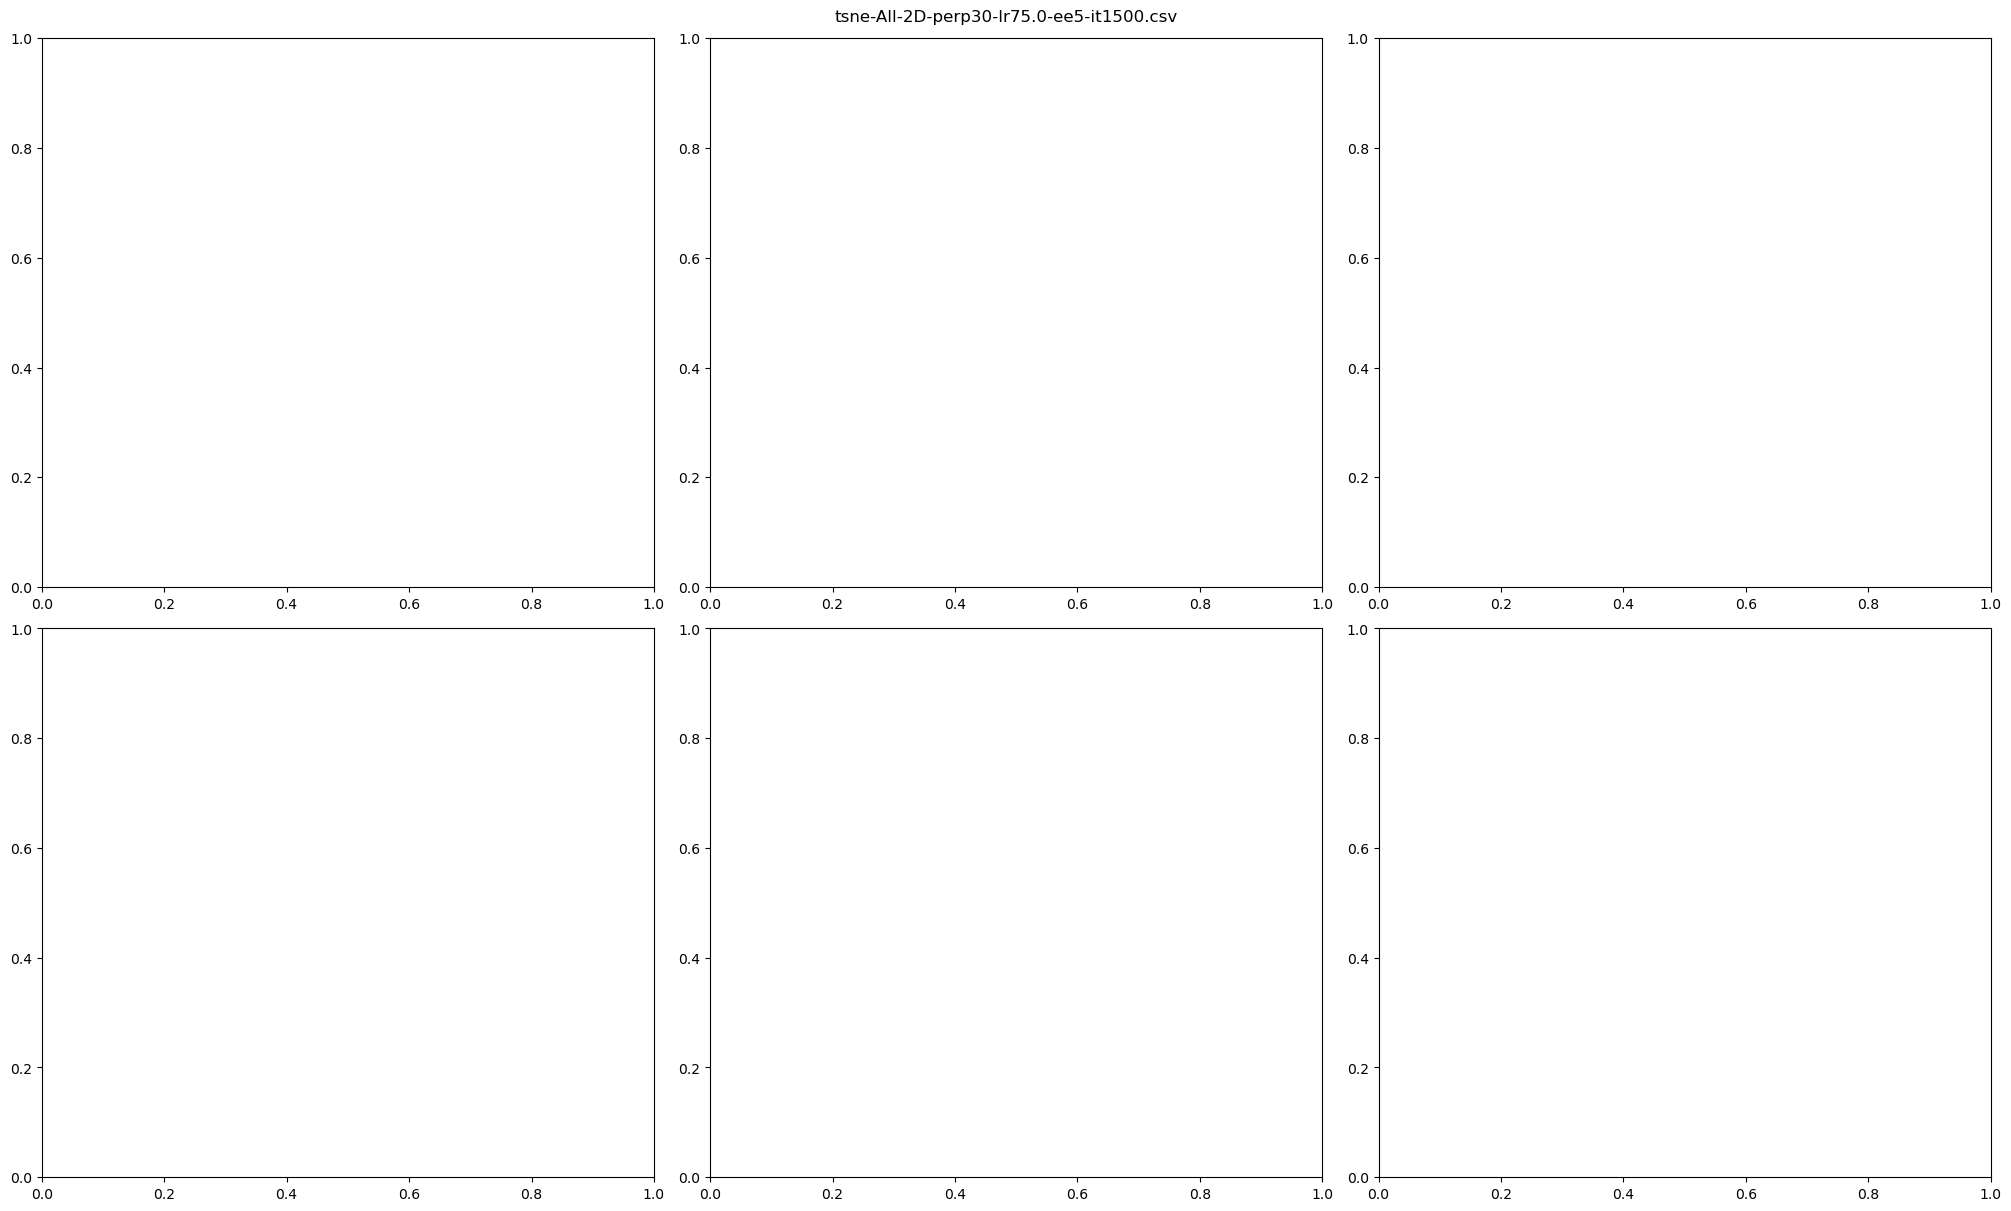

In [9]:
# Plot
fig, axs = plt.subplots(2, 3, figsize=(20, 12),constrained_layout = True)
fig.suptitle(tsne_file)
colourmap_hard = 'viridis_r'
colourmap_var = 'plasma_r'

hard_hm = axs[0,0].scatter(df_tsne['tsne1'], df_tsne['tsne2'],c=df_properties['hard_hm'], s=0.1, cmap=colourmap_hard)
axs[0,0].set_xlabel('TSNE dimension 1')
axs[0,0].set_ylabel('TSNE dimension 2')
axs[0,0].set_title(f'hard_hm')
fig.colorbar(hard_hm, ax = axs[0,0])

hard_hs = axs[0,1].scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_properties['hard_hs'], s=0.1, cmap=colourmap_hard)
axs[0,1].set_xlabel('TSNE dimension 1')
axs[0,1].set_ylabel('TSNE dimension 2')
axs[0,1].set_title(f'hard_hs')
fig.colorbar(hard_hs, ax = axs[0,1])

hard_ms = axs[0,2].scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_properties['hard_ms'], s=0.1, cmap=colourmap_hard)
axs[0,2].set_xlabel('TSNE dimension 1')
axs[0,2].set_ylabel('TSNE dimension 2')
axs[0,2].set_title(f'hard_ms')
fig.colorbar(hard_ms, ax = axs[0,2])

var_h = axs[1,0].scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_properties['var_prob_h'], s=0.1, cmap=colourmap_var)
axs[1,0].set_xlabel('TSNE dimension 1')
axs[1,0].set_ylabel('TSNE dimension 2')
axs[1,0].set_title(f'var_prob_h')
fig.colorbar(var_h, ax = axs[1,0])

var_m = axs[1,1].scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_properties['var_prob_m'], s=0.1, cmap=colourmap_var)
axs[1,1].set_xlabel('TSNE dimension 1')
axs[1,1].set_ylabel('TSNE dimension 2')
axs[1,1].set_title(f'var_prob_m')
fig.colorbar(var_m, ax = axs[1,1])

var_s = axs[1,2].scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_properties['var_prob_s'], s=0.1, cmap=colourmap_var)
axs[1,2].set_xlabel('TSNE dimension 1')
axs[1,2].set_ylabel('TSNE dimension 2')
axs[1,2].set_title(f'var_prob_s')
fig.colorbar(var_s, ax = axs[1,2])

for ax in axs.flatten()[0:1]:
    ax.scatter(tsne_flares['tsne1'], tsne_flares['tsne2'], c='red', marker='x', s=100, label='Flares')
    ax.scatter(tsne_dips['tsne1'], tsne_dips['tsne2'], c='blue', marker='x', s=100, label='Dips')
    ax.scatter(tsne_rosanne['tsne1'], tsne_rosanne['tsne2'], c='black', marker='x', s=100, label='Rosanne')
    ax.legend()

plt.show()

# IV. UMAP

UMAP Model

In [45]:
# pca Setting
n_comp = 2
neighbours = 70
min_d = 0.1
learn_rate = 0.1
sp = 2

# Define pca Model
umap_model = umap.UMAP(n_components = n_comp, n_neighbors = neighbours, min_dist = min_d, learning_rate = learn_rate, random_state=42, spread = sp)
# Run pca Model on Data
umap_out = umap_model.fit_transform(features)
print(umap_out.shape)

# Save pca Output
df_umap = pd.DataFrame(umap_out, columns=['umap1', 'umap2'])
df_umap['obsreg_id'] = list(ids)
input_file = input_widget.value
data_rep = input_file.split(".pkl")[0]
df_umap.to_csv(f'{global_path}/{set_id}/umap-{set_id}-{data_rep}-{n_comp}D-neighb{neighbours}-mind-{min_d}-lr{learn_rate}-sp{sp}.csv', index=False)



(82283, 2)


Plot UMAP

In [46]:
files = os.listdir(f'{global_path}/{set_id}/')
umap_files = [f for f in files if fnmatch.fnmatch(f, 'umap*')]
umap_widget = widgets.Dropdown(options=umap_files[:],value=umap_files[0],description='UMAP File :',disabled=False); umap_widget

Dropdown(description='UMAP File :', options=('umap-All-histEt-All-nE20-nt25-normnone-2D-neighb50-mind-0.1-lr0.…

In [47]:
# Load the DataFrame from the CSV file
umap_file = umap_widget.value
df_umap = pd.read_csv(f'{global_path}/{set_id}/{umap_file}')
# Use loc to select rows that match the IDs in list2, and store the result in a new DataFrame
flares = ['9109_333','9109_344','13637_1078','14368_489','14368_503','14431_16','14542_18','10822_185','10955_21','10996_5','2833_53','13610_112','15214_29']
dips = ['10783_10','10871_10','11059_10','9070_10','9072_10','13814_567','13682_9','1708_192','1708_193','1712_91','15553_237','13681_9','13813_86']
rosanne = ['13814_567']
umap_flares = df_umap.loc[df_umap['obsreg_id'].isin(flares)]
umap_dips = df_umap.loc[df_umap['obsreg_id'].isin(dips)]
umap_rosanne = df_umap.loc[df_umap['obsreg_id'].isin(rosanne)]

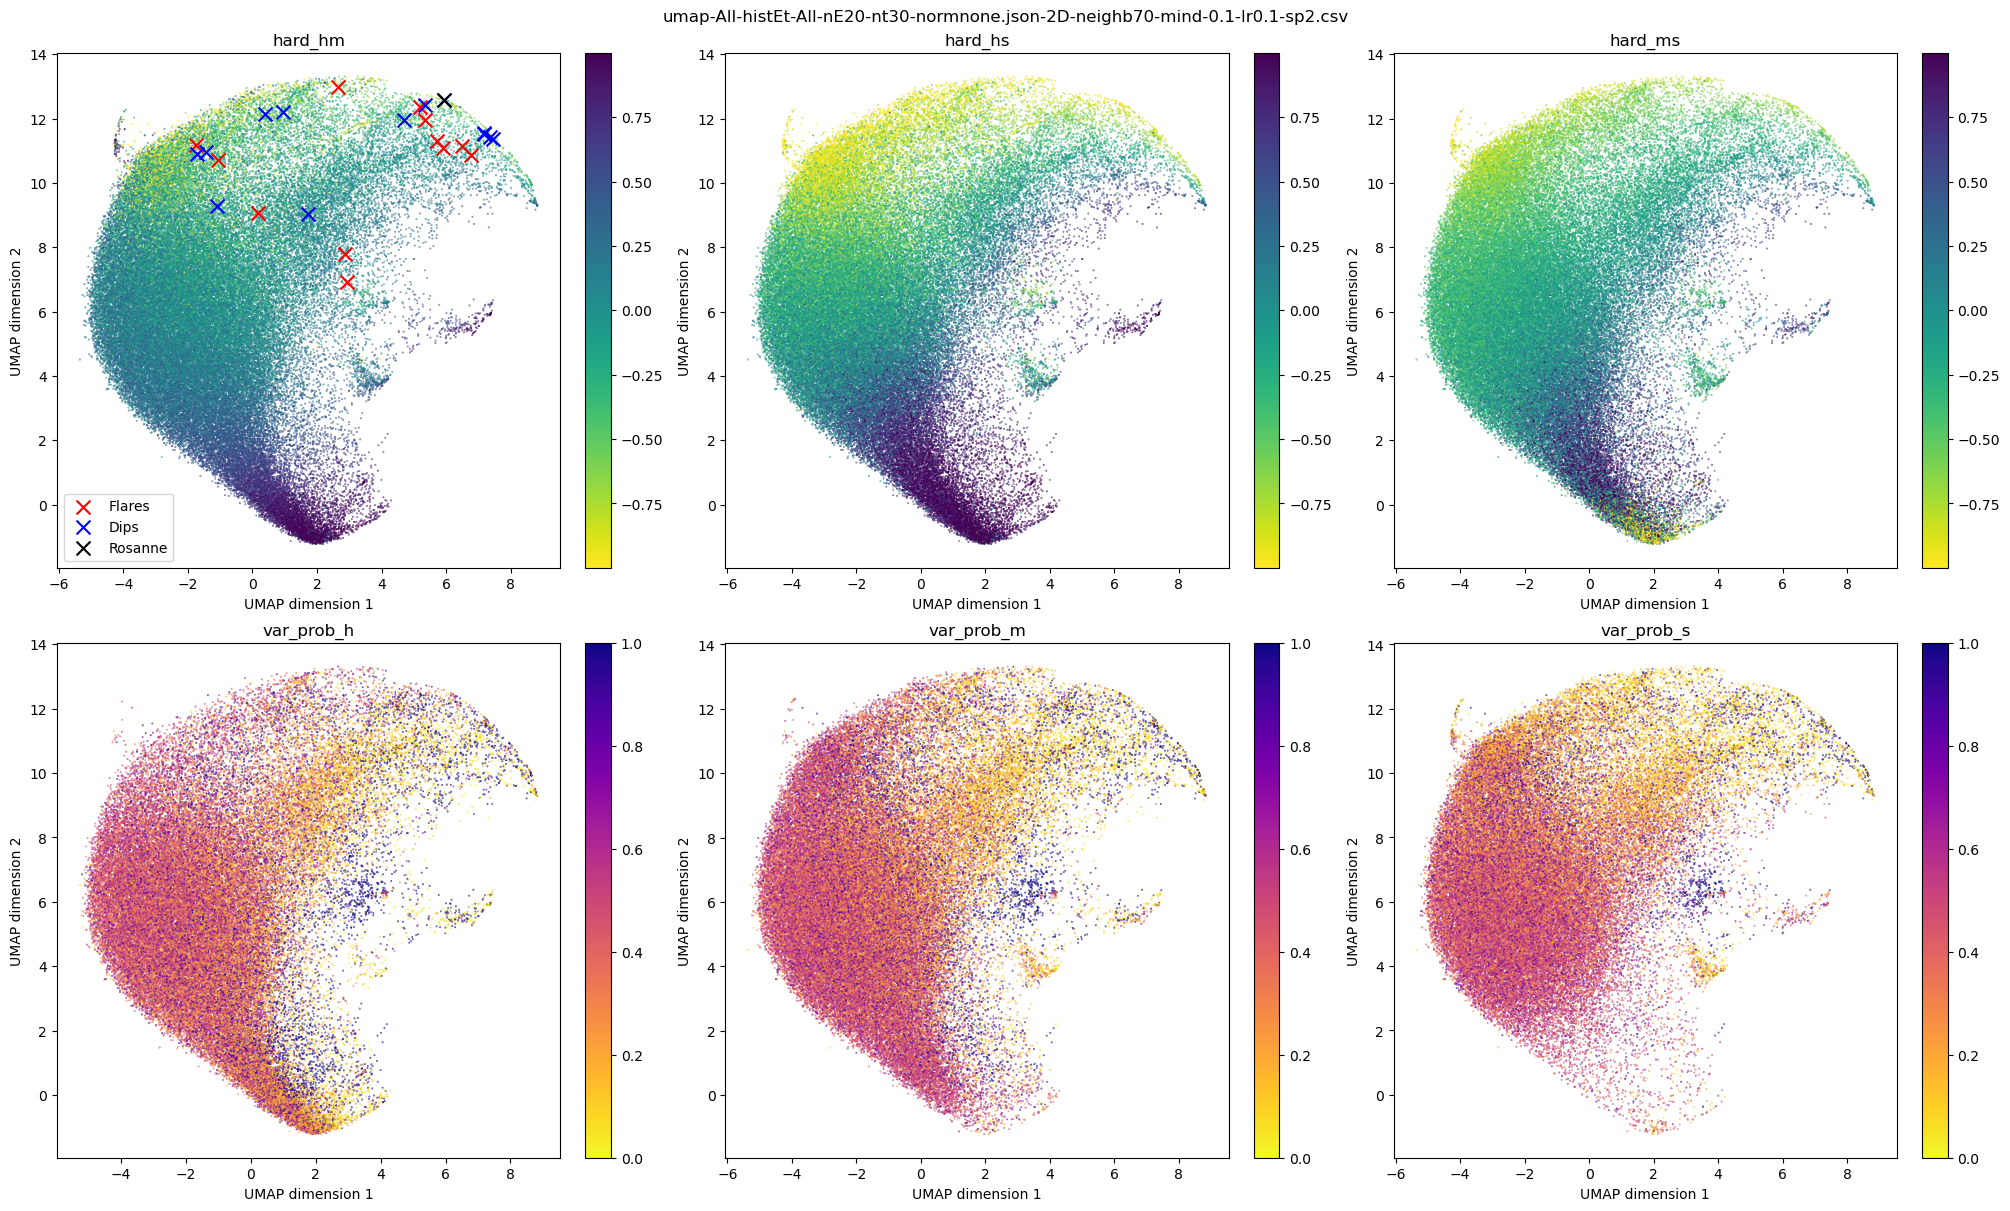

In [48]:
# Plot
fig, axs = plt.subplots(2, 3, figsize=(20, 12),constrained_layout = True)
fig.suptitle(umap_file)
colourmap_hard = 'viridis_r' #inferno 'viridis_r' 'plasma_r'
colourmap_var = 'plasma_r'

hard_hm = axs[0,0].scatter(df_umap['umap1'], df_umap['umap2'],c=df_properties['hard_hm'], s=0.1, cmap=colourmap_hard)
axs[0,0].set_xlabel('UMAP dimension 1')
axs[0,0].set_ylabel('UMAP dimension 2')
axs[0,0].set_title(f'hard_hm')
fig.colorbar(hard_hm, ax = axs[0,0])

hard_hs = axs[0,1].scatter(df_umap['umap1'], df_umap['umap2'], c=df_properties['hard_hs'], s=0.1, cmap=colourmap_hard)
axs[0,1].set_xlabel('UMAP dimension 1')
axs[0,1].set_ylabel('UMAP dimension 2')
axs[0,1].set_title(f'hard_hs')
fig.colorbar(hard_hs, ax = axs[0,1])

hard_ms = axs[0,2].scatter(df_umap['umap1'], df_umap['umap2'], c=df_properties['hard_ms'], s=0.1, cmap=colourmap_hard)
axs[0,2].set_xlabel('UMAP dimension 1')
axs[0,2].set_ylabel('UMAP dimension 2')
axs[0,2].set_title(f'hard_ms')
fig.colorbar(hard_ms, ax = axs[0,2])

var_h = axs[1,0].scatter(df_umap['umap1'], df_umap['umap2'], c=df_properties['var_prob_h'], s=0.1, cmap=colourmap_var)
axs[1,0].set_xlabel('UMAP dimension 1')
axs[1,0].set_ylabel('UMAP dimension 2')
axs[1,0].set_title(f'var_prob_h')
fig.colorbar(var_h, ax = axs[1,0])

var_m = axs[1,1].scatter(df_umap['umap1'], df_umap['umap2'], c=df_properties['var_prob_m'], s=0.1, cmap=colourmap_var)
axs[1,1].set_xlabel('UMAP dimension 1')
axs[1,1].set_ylabel('UMAP dimension 2')
axs[1,1].set_title(f'var_prob_m')
fig.colorbar(var_m, ax = axs[1,1])

var_s = axs[1,2].scatter(df_umap['umap1'], df_umap['umap2'], c=df_properties['var_prob_s'], s=0.1, cmap=colourmap_var)
axs[1,2].set_xlabel('UMAP dimension 1')
axs[1,2].set_ylabel('UMAP dimension 2')
axs[1,2].set_title(f'var_prob_s')
fig.colorbar(var_s, ax = axs[1,2])

for ax in axs.flatten()[0:1]:
    ax.scatter(umap_flares['umap1'], umap_flares['umap2'], c='red', marker='x', s=100, label='Flares')
    ax.scatter(umap_dips['umap1'], umap_dips['umap2'], c='blue', marker='x', s=100, label='Dips')
    ax.scatter(umap_rosanne['umap1'], umap_rosanne['umap2'], c='black', marker='x', s=100, label='Rosanne')
    ax.legend()

plt.show()

# V. PCA

In [5]:
# Run PCA
pca_model = PCA(n_components=2)
pca_out = pca_model.fit_transform(features) 

# Save UMAP Output
df_pca = pd.DataFrame(pca_out, columns=['pca1', 'pca2'])
df_pca['obsreg_id'] = list(ids)
input_file = input_widget.value
data_rep = input_file.split(".pkl")[0]
df_pca.to_csv(f'{global_path}/{set_id}/pca-{set_id}-{data_rep}.csv', index=False)

In [12]:
files = os.listdir(f'{global_path}/{set_id}/')
pca_files = [f for f in files if fnmatch.fnmatch(f, 'pca*')]
pca_widget = widgets.Dropdown(options=pca_files[:],value=pca_files[0],description='PCA File :',disabled=False); pca_widget

Dropdown(description='PCA File :', options=('pca-All-hist3D-All-nE20-nt30-ndt35.csv',), value='pca-All-hist3D-…

In [14]:
# Load the DataFrame from the CSV file
pca_file = pca_widget.value
df_pca = pd.read_csv(f'{global_path}/{set_id}/{pca_file}')
# Use loc to select rows that match the IDs in list2, and store the result in a new DataFrame
flares = ['9109_333','9109_344','13637_1078','14368_489','14368_503','14431_16','14542_18','10822_185','10955_21','10996_5','2833_53','13610_112','15214_29']
dips = ['10783_10','10871_10','11059_10','9070_10','9072_10','13814_567','13682_9','1708_192','1708_193','1712_91','15553_237','13681_9','13813_86']
rosanne = ['13814_567']
pca_flares = df_pca.loc[df_pca['obsreg_id'].isin(flares)]
pca_dips = df_pca.loc[df_pca['obsreg_id'].isin(dips)]
pca_rosanne = df_pca.loc[df_pca['obsreg_id'].isin(rosanne)]

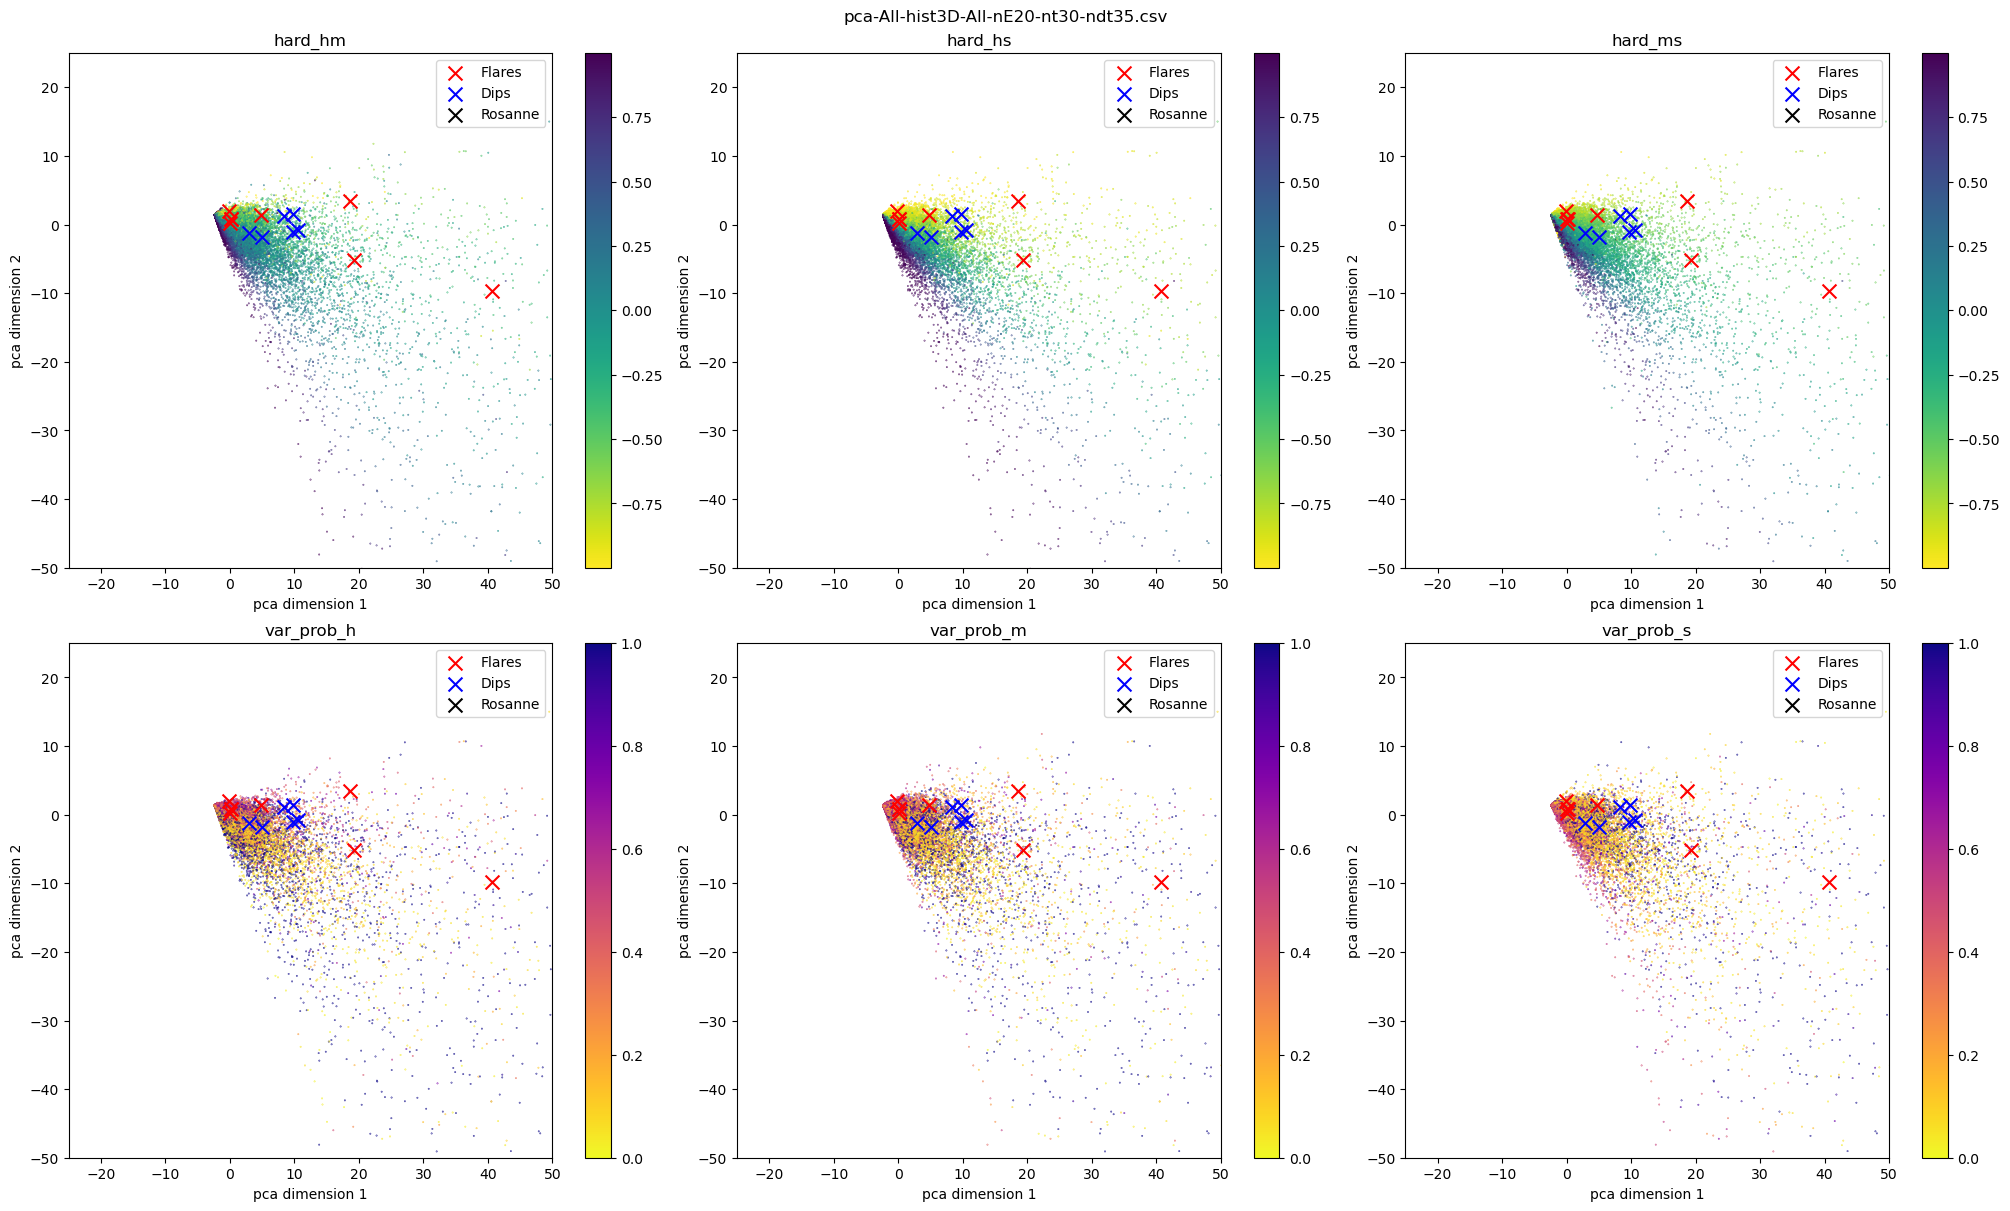

In [18]:
# Plot
fig, axs = plt.subplots(2, 3, figsize=(20, 12),constrained_layout = True)
fig.suptitle(pca_file)
colourmap_hard = 'viridis_r' #inferno 'viridis_r' 'plasma_r'
colourmap_var = 'plasma_r'

hard_hm = axs[0,0].scatter(df_pca['pca1'], df_pca['pca2'],c=df_properties['hard_hm'], s=0.1, cmap=colourmap_hard)
axs[0,0].set_xlabel('pca dimension 1')
axs[0,0].set_ylabel('pca dimension 2')
axs[0,0].set_title(f'hard_hm')
fig.colorbar(hard_hm, ax = axs[0,0])

hard_hs = axs[0,1].scatter(df_pca['pca1'], df_pca['pca2'], c=df_properties['hard_hs'], s=0.1, cmap=colourmap_hard)
axs[0,1].set_xlabel('pca dimension 1')
axs[0,1].set_ylabel('pca dimension 2')
axs[0,1].set_title(f'hard_hs')
fig.colorbar(hard_hs, ax = axs[0,1])

hard_ms = axs[0,2].scatter(df_pca['pca1'], df_pca['pca2'], c=df_properties['hard_ms'], s=0.1, cmap=colourmap_hard)
axs[0,2].set_xlabel('pca dimension 1')
axs[0,2].set_ylabel('pca dimension 2')
axs[0,2].set_title(f'hard_ms')
fig.colorbar(hard_ms, ax = axs[0,2])

var_h = axs[1,0].scatter(df_pca['pca1'], df_pca['pca2'], c=df_properties['var_prob_h'], s=0.1, cmap=colourmap_var)
axs[1,0].set_xlabel('pca dimension 1')
axs[1,0].set_ylabel('pca dimension 2')
axs[1,0].set_title(f'var_prob_h')
fig.colorbar(var_h, ax = axs[1,0])

var_m = axs[1,1].scatter(df_pca['pca1'], df_pca['pca2'], c=df_properties['var_prob_m'], s=0.1, cmap=colourmap_var)
axs[1,1].set_xlabel('pca dimension 1')
axs[1,1].set_ylabel('pca dimension 2')
axs[1,1].set_title(f'var_prob_m')
fig.colorbar(var_m, ax = axs[1,1])

var_s = axs[1,2].scatter(df_pca['pca1'], df_pca['pca2'], c=df_properties['var_prob_s'], s=0.1, cmap=colourmap_var)
axs[1,2].set_xlabel('pca dimension 1')
axs[1,2].set_ylabel('pca dimension 2')
axs[1,2].set_title(f'var_prob_s')
fig.colorbar(var_s, ax = axs[1,2])

for ax in axs.flatten():
    ax.scatter(pca_flares['pca1'], pca_flares['pca2'], c='red', marker='x', s=100, label='Flares')
    ax.scatter(pca_dips['pca1'], pca_dips['pca2'], c='blue', marker='x', s=100, label='Dips')
    ax.scatter(pca_rosanne['pca1'], pca_rosanne['pca2'], c='black', marker='x', s=100, label='Rosanne')
    ax.set_xlim([-25,50])
    ax.set_ylim([-50,25])
    ax.legend()

plt.show()